# Проект по классификации изображений

Будем решать достаточно известную задачу классификации персонажей всем известного мультсериала








![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Данные можно скачать [ссылке](https://disk.yandex.ru/d/U9bpivZ-Tpknfw).



In [1]:
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/U9bpivZ-Tpknfw) -o simspons.zip
!unzip -qq simspons.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  520M  100  520M    0     0  11.7M      0  0:00:44  0:00:44 --:--:-- 13.7M


In [2]:
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import time
import os
import math
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from PIL import Image
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet

Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. Картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample).

Для данных из трейна делаем аугментацию.

In [4]:
# разные режимы загрузки датасета
data_modes = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        trs = transforms.TrivialAugmentWide(num_magnitude_bins=5)
        image = image.resize((224, 224))
        if self.mode == 'train':
          image = trs(image)
        return np.array(image)

Читаем данные

In [5]:
train_dir = Path('train/simpsons_dataset')
test_dir = Path('testset/testset')

train_val_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

Разделяем на выборки

In [6]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Создаем датасеты - объекты класса Simpsonsdataset

In [7]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [8]:
train_dataset.__getitem__(1)

(tensor([[[-1.1589, -1.1589, -1.1589,  ...,  0.0398,  0.0741,  0.0741],
          [-0.6452, -0.6452, -0.6452,  ...,  0.6049,  0.6392,  0.6392],
          [-0.3369, -0.3369, -0.3369,  ...,  0.7591,  0.7248,  0.7591],
          ...,
          [-1.3644, -1.3644, -1.3644,  ...,  1.0502,  1.0844,  1.0502],
          [-1.3644, -1.3644, -1.3644,  ...,  1.4098,  1.4440,  1.4098],
          [-1.3644, -1.3644, -1.3644,  ...,  1.1187,  1.1187,  1.1187]],
 
         [[-1.8431, -1.8431, -1.8431,  ..., -1.7556, -1.7206, -1.7556],
          [-1.3179, -1.3179, -1.3179,  ..., -1.1604, -1.1429, -1.1429],
          [-1.0203, -1.0203, -1.0203,  ..., -0.9853, -1.0203, -1.0203],
          ...,
          [-1.0553, -1.0553, -1.0553,  ...,  1.4307,  1.4307,  1.4482],
          [-1.0553, -1.0553, -1.0553,  ...,  1.6057,  1.5707,  1.6057],
          [-1.0553, -1.0553, -1.0553,  ...,  1.1856,  1.1856,  1.1856]],
 
         [[-0.1835, -0.1835, -0.1835,  ..., -1.0027, -0.9678, -1.0027],
          [ 0.3393,  0.3393,

Определим функции для отображения картинок и выведем 9 случайных из трейна

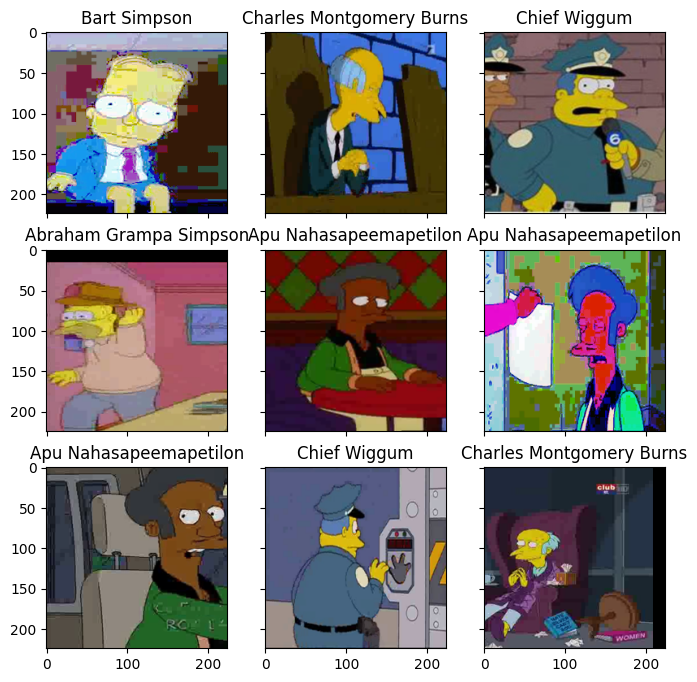

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    plt_ax.set_title(title)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 5000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

Проверка на сбалансированность классов

In [10]:
min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(train_dir)):
    folder_num = len(os.listdir(os.path.join(train_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder

num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder_name)
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
groundskeeper_willie 121
martin_prince        71
troy_mcclure         8
apu_nahasapeemapetilon 623
kent_brockman        498
ralph_wiggum         89
selma_bouvier        103
abraham_grampa_simpson 913
miss_hoover          17
carl_carlson         98
chief_wiggum         986
lionel_hutz          3
fat_tony             27
barney_gumble        106
charles_montgomery_burns 1193
edna_krabappel       457
professor_john_frink 65
principal_skinner    1194
ned_flanders         1454
maggie_simpson       128
sideshow_bob         877
waylon_smithers      181
homer_simpson        2246
otto_mann            32
rainier_wolfcastle   45
patty_bouvier        72
bart_simpson         1342
agnes_skinner        42
mayor_quimby         246
nelson_muntz         358
cletus_spuckler      47
moe_szyslak          1452
krusty_the_clown     1206
comic_book_guy       469
disco_stu            8
marge_simpson        1291
lisa_simpson         1354
lenny_leonard        310


Видим, что представленность классов находится в сильном дисбалансе. Эту проблему можно решить двумя путями - либо передачей весов класов в функцию потерь, либо оверсэмплингом - наращиванием миноритарных классов и разнообразной их аугментацией. Ввиду ограничения вычислительных мощностей воспользуемся первой опцией (далее, при построении модели).

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Создаем загрузчики данных, по 32 элемента в каждом батче

In [12]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

Проверяем размерность батча и как выглядит теперь тензор изображения

In [13]:
img, label = next(iter(train_loader))
print(f"Размерность изображения: {img.shape} -> [размер батча, цветовые каналы, высота, ширина]")

Размерность изображения: torch.Size([32, 3, 224, 224]) -> [размер батча, цветовые каналы, высота, ширина]


In [14]:
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"Тензор изображения:\n{img}")
print(f"Размерность тензора: {img.shape}")
print(f"Тип данных: {img.dtype}")
print(f"Класс изображения: {label}")

Тензор изображения:
tensor([[[-0.5767, -0.5767, -0.5767,  ...,  0.2796,  0.2796,  0.2796],
         [-0.5767, -0.5767, -0.5767,  ...,  0.2796,  0.2796,  0.2796],
         [-0.5767, -0.5767, -0.5767,  ...,  0.2796,  0.2796,  0.2796],
         ...,
         [-1.4329, -0.5424,  0.5878,  ..., -0.0629, -0.0287,  0.2967],
         [-0.9705, -1.1075, -0.3027,  ..., -0.3198, -0.5082,  0.0227],
         [ 0.0398, -0.4911, -0.9192,  ..., -0.4911, -0.8678, -0.1828]],

        [[-0.1625, -0.1625, -0.1625,  ...,  0.5378,  0.5378,  0.5378],
         [-0.1625, -0.1625, -0.1625,  ...,  0.5378,  0.5378,  0.5378],
         [-0.1625, -0.1625, -0.1625,  ...,  0.5378,  0.5378,  0.5378],
         ...,
         [-1.0553, -0.1625,  0.9580,  ..., -0.2500, -0.1275,  0.2577],
         [-0.5476, -0.7227,  0.0651,  ..., -0.5126, -0.6176, -0.0399],
         [ 0.5028, -0.0749, -0.5651,  ..., -0.7052, -0.9853, -0.2500]],

        [[ 1.0017,  1.0017,  1.0017,  ...,  1.2457,  1.2457,  1.2457],
         [ 1.0017,  1.001

# **Построение модели**

Создаем веса для классов из-за их дисбаланса

In [15]:
import sklearn
from sklearn.utils.class_weight import compute_class_weight

In [16]:
label_encoder = LabelEncoder()

In [17]:
label_encoder.fit(train_dataset.labels)

LabelEncoder()

In [18]:
classlist = train_dataset.labels
classlist = label_encoder.transform(classlist)

In [19]:
classlist

array([ 0,  0,  0, ..., 41, 41, 41])

In [20]:
classlist = torch.Tensor(classlist)

In [21]:
classlist

tensor([ 0.,  0.,  0.,  ..., 41., 41., 41.])

In [22]:
class_weights = compute_class_weight('balanced', classes = np.unique(classlist), y = classlist.numpy())
class_weights = torch.tensor(class_weights,dtype=torch.float)

In [23]:
class_weights

tensor([  0.5457,  11.6808,   0.8004,   4.6723,   0.3716,   5.0512,   0.4176,
          0.5058,  10.6796,   1.0619,  62.2976,   1.0898,  18.6893,  18.6893,
          4.1075,   0.2220,   1.0021,   0.4135,   1.6042, 186.8929,   0.3683,
          3.8936,   0.3861,   7.0526,   2.0205,   0.4620,  28.7527,   0.3432,
          0.3429,   1.3895,  15.5744,   6.9220,   0.4176,   7.6283,  10.9937,
          5.5789,   4.8544,   0.5681,  12.4595,   9.1167,  62.2976,   2.7484])

## Вручную заданная архитектура

Пишем функции для обучения и оценки

In [24]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    since = time.time()
    model.to(device)
    model.train()

    for epoch in range(epochs):
        # итерируем по батчам на трейне
        for X_batch, y_batch in train_loader:
            # переводим батчи на GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # получаем предсказания модели для батча
            y_pred = model(X_batch)
            # # вычисляем функцию потерь для батча
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # вызываем функцию evaluate на валидации и получаем значения функции потерь и точности
        print(f'Эпоха {epoch+1}')
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model

def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    correct = 0
    model.to(device)
    # переводим модель в режим оценки
    model.eval()
    # включаем контекстный менеджер для инференса
    with torch.inference_mode():
        # итерируем по батчам
        for X, y in data_loader:
            # переводим батчи на GPU
            X, y = X.to(device), y.to(device)
            # делаем предсказания модели
            pred = model(X)
            # вычисляем функцию потерь
            loss = loss_fn(pred, y)
            # добавляем функцию потерь к суммарной
            total_loss += loss.item()
            # получаем индексы максимальных значений в предсказаниях модели
            pred = torch.argmax(pred, dim=1)
            # сравниваем предсказания модели с метками и считаем, сколько раз они совпадают
            correct += torch.sum(pred == y).item()

    # вычисляем среднюю функцию потерь по данным
    mean_loss = total_loss / len(data_loader)
    # вычисляем точность по данным
    accuracy = correct / len(data_loader.dataset)


    print(f"Функция потерь (кросс-энтропия) на данных {mean_loss}")
    print(f"Точность на данных {accuracy}")

    return mean_loss, accuracy


In [25]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для первой пробы задаем архитектуру модели вручную

In [ ]:
class ARCH1_NN(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
               out_channels=hidden_units,
               kernel_size=3),  # выход будет 222х222 (224-3+1)
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.Dropout(0.1), # снизим дропаут из-за малого количества данных
      nn.Conv2d(in_channels=hidden_units,
               out_channels=hidden_units,
               kernel_size=3),  # выход будет 220х220 (222-3+1)
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)  # выход будет 110х110
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(hidden_units, hidden_units, 3),  # выход будет 108х108
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.Dropout(0.1),  # снизим дропаут
      nn.Conv2d(hidden_units, hidden_units, 3), # выход будет 106х106
      nn.BatchNorm2d(hidden_units),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)  # выход будет 53х53
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 53 * 53,
               out_features=output_shape),
      nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
model = ARCH1_NN(3, 224, 42)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


trained_model = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
trained_model

На определенном этапе обучение было прервано вручную, так как очевидно, что данная архитектура не подходит под сложные и большие изображения. Модель обучалась плохо, показывала очень низкую точность, было принято решение не тратить вычислительные мощности и перейти к transfer learning.

## Предобученная модель AlexNet

Для начала проверим работу нескольких предобученных моделей, предварительно заморозив в них все слои до полносвязной нейросети.

In [29]:
weights = models.AlexNet_Weights.DEFAULT
model = models.alexnet(weights=weights)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 219MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [30]:
len(list(model.children()))

3

Функция для создания модели с преобразованием последнего слоя под нужное количество классов и заморозкой нужного числа слоёв

In [31]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [32]:
model = create_model(model, 2, 42)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
 class_weights.to(device)

tensor([  0.5457,  11.6808,   0.8004,   4.6723,   0.3716,   5.0512,   0.4176,
          0.5058,  10.6796,   1.0619,  62.2976,   1.0898,  18.6893,  18.6893,
          4.1075,   0.2220,   1.0021,   0.4135,   1.6042, 186.8929,   0.3683,
          3.8936,   0.3861,   7.0526,   2.0205,   0.4620,  28.7527,   0.3432,
          0.3429,   1.3895,  15.5744,   6.9220,   0.4176,   7.6283,  10.9937,
          5.5789,   4.8544,   0.5681,  12.4595,   9.1167,  62.2976,   2.7484],
       device='cuda:0')

Передадим также наши веса для устранения дисбаланса классов и более правильного расчета accuracy

In [34]:
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [35]:
 loss_fn.to(device)

CrossEntropyLoss()

In [38]:
trained_model = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=18)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 3.0765415749898772
Точность на данных 0.27818112342376766
Эпоха 2
Функция потерь (кросс-энтропия) на данных 2.1818639861374365
Точность на данных 0.4910202521971723
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.7156897736031835
Точность на данных 0.5794803209782193
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.4361705363887112
Точность на данных 0.6411922048146733
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.2323002877031886
Точность на данных 0.6916316392816202
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.149196003177544
Точность на данных 0.7057699656094765
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.1027931474694392
Точность на данных 0.7208635842567825
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.0102758523440216
Точность на данных 0.7413068398930073
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.9506969034853505
Точность на данных 0.7609858616736721
Эпоха 10
Функция потерь (кросс-энтроп

## VGG19

Аналогичным образов проверим работу модели VGG19

In [39]:
weights = models.VGG19_Weights.DEFAULT
model = models.vgg19(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s]


In [40]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [41]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [43]:
model = create_model(model, 2, 42)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

loss_fn.to(device)

trained_model = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=18)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 3.338064480118635
Точность на данных 0.2273595720290409
Эпоха 2
Функция потерь (кросс-энтропия) на данных 2.7422919694970296
Точность на данных 0.3404661826518915
Эпоха 3
Функция потерь (кросс-энтропия) на данных 2.044330642354198
Точность на данных 0.49904470768055026
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.7062417417764664
Точность на данных 0.5682078716087122
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.5189183172656269
Точность на данных 0.607565915170042
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.3979007668974923
Точность на данных 0.6366068016813144
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.2289628315626122
Точность на данных 0.6904852884982805
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.2062552191498803
Точность на данных 0.6975544516622086
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.1097199142706105
Точность на данных 0.7214367596484524
Эпоха 10
Функция потерь (кросс-энтропия

## ResNet

Проверяем ResNet

In [46]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


In [47]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(in_features=512, out_features=num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

In [50]:
model = create_model(model, 9, 42)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [52]:
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


loss_fn.to(device)

trained_model = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=18)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 3.085013508796692
Точность на данных 0.3400840657241116
Эпоха 2
Функция потерь (кросс-энтропия) на данных 2.8059519398503188
Точность на данных 0.48586167367214367
Эпоха 3
Функция потерь (кросс-энтропия) на данных 2.578659901531731
Точность на данных 0.5489109667558273
Эпоха 4
Функция потерь (кросс-энтропия) на данных 2.406983585619345
Точность на данных 0.5756591517004204
Эпоха 5
Функция потерь (кросс-энтропия) на данных 2.216401844489865
Точность на данных 0.6090943828811617
Эпоха 6
Функция потерь (кросс-энтропия) на данных 2.126535137978996
Точность на данных 0.6331677493312954
Эпоха 7
Функция потерь (кросс-энтропия) на данных 2.0034656328399008
Точность на данных 0.6385173863202139
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.9547536038770907
Точность на данных 0.6438670233091326
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.822059213388257
Точность на данных 0.6589606419564387
Эпоха 10
Функция потерь (кросс-энтропия) н

## AlexNet без заморозки слоёв

Возьмем архитектуру AlexNet и обучим модель полностью на наших данных

In [26]:
weights = models.AlexNet_Weights.DEFAULT
model = models.alexnet(weights=weights)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 198MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
 model.classifier[6] = nn.Linear(in_features=4096, out_features=42)

In [29]:
class_weights.to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn.to(device)

CrossEntropyLoss()

In [30]:
trained_model = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=18)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.288271724450879
Точность на данных 0.6687046236148262
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.922533880150806
Точность на данных 0.7640427970959114
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.7810072735315416
Точность на данных 0.7948032097821933
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.1341839235207838
Точность на данных 0.7101643102789453
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.6475977595872814
Точность на данных 0.8828811616354605
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.5551904774826054
Точность на данных 0.8796331677493313
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.6160210390751273
Точность на данных 0.8763851738632021
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.6025946284587518
Точность на данных 0.8828811616354605
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.6283413524843792
Точность на данных 0.8758119984715322
Эпоха 10
Функция потерь (кросс-энтропия

# Анализ результатов

## Анализ ошибок

In [31]:
# Получаем тестовые данные из test_loader
x_test = []
y_test = []
for images, labels in val_loader:
    x_test.append(images)
    y_test.append(labels)
x_test = torch.cat(x_test, dim=0)
y_test = torch.cat(y_test, dim=0)

# Делаем прогнозы с помощью trained_model
y_pred = trained_model(x_test.to(device))
y_pred_classes = y_pred.argmax(dim=1).cpu()

In [33]:
from sklearn.metrics import confusion_matrix

In [35]:
import seaborn as sns

In [46]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                       index=[f"y_true={i}" for i in range(0, 42)],
                       columns=[f"y_pred={i}" for i in range(0, 42)])
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    return df_conf

In [41]:
conf = confusion_matrix(y_test, y_pred_classes)

conf

array([[213,   0,   0, ...,   0,   0,   0],
       [  0,   8,   0, ...,   0,   0,   0],
       [  0,   0, 143, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  11,   0,   0],
       [  0,   0,   0, ...,   0,   1,   0],
       [  0,   0,   0, ...,   0,   0,  36]])

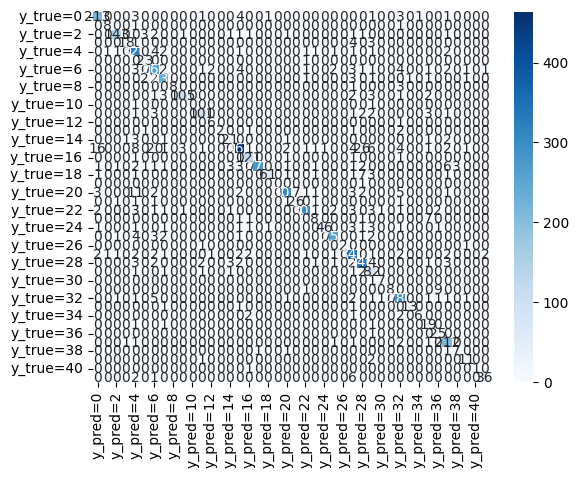

In [44]:
showmatrix(conf)

,y_pred=0,y_pred=1,y_pred=2,y_pred=3,y_pred=4,y_pred=5,y_pred=6,y_pred=7,y_pred=8,y_pred=9,...,y_pred=32,y_pred=33,y_pred=34,y_pred=35,y_pred=36,y_pred=37,y_pred=38,y_pred=39,y_pred=40,y_pred=41
y_true=0,213,0,0,0,3,0,0,0,0,0,...,3,0,1,0,0,1,0,0,0,0
y_true=1,0,8,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
y_true=2,0,0,143,0,0,3,2,0,0,1,...,0,0,0,0,0,1,0,0,0,0
y_true=3,0,0,0,18,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
y_true=4,0,1,1,0,320,0,4,2,0,0,...,0,0,0,0,0,2,0,0,0,0
y_true=5,0,0,0,0,0,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
y_true=6,0,0,0,0,3,0,269,2,0,0,...,4,0,0,1,0,2,0,1,0,1
y_true=7,0,0,0,0,0,2,2,235,0,0,...,0,1,0,1,0,0,0,1,0,0
y_true=8,0,0,0,0,0,0,0,0,8,0,...,3,0,0,0,0,0,0,0,0,0
y_true=9,0,0,0,0,0,0,1,3,0,105,...,1,0,0,2,0,0,0,0,0,0


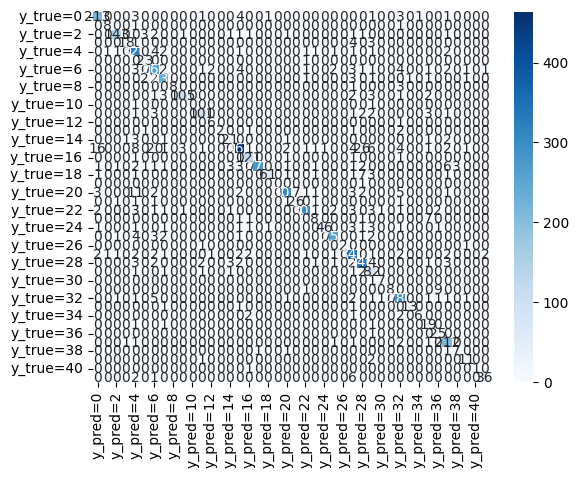

In [47]:
showme = showmatrix(conf)

showme

In [52]:
class_names

['groundskeeper_willie',
 'martin_prince',
 'troy_mcclure',
 'apu_nahasapeemapetilon',
 'kent_brockman',
 'ralph_wiggum',
 'selma_bouvier',
 'abraham_grampa_simpson',
 'miss_hoover',
 'carl_carlson',
 'chief_wiggum',
 'lionel_hutz',
 'fat_tony',
 'barney_gumble',
 'charles_montgomery_burns',
 'edna_krabappel',
 'professor_john_frink',
 'principal_skinner',
 'ned_flanders',
 'maggie_simpson',
 'sideshow_bob',
 'waylon_smithers',
 'homer_simpson',
 'otto_mann',
 'rainier_wolfcastle',
 'patty_bouvier',
 'bart_simpson',
 'agnes_skinner',
 'mayor_quimby',
 'nelson_muntz',
 'cletus_spuckler',
 'moe_szyslak',
 'krusty_the_clown',
 'comic_book_guy',
 'disco_stu',
 'marge_simpson',
 'lisa_simpson',
 'lenny_leonard',
 'sideshow_mel',
 'gil',
 'snake_jailbird',
 'milhouse_van_houten']

homer_simpson принимается за charles_montgomery_burns - 20 ошибочных предсказаний

In [54]:
label_encoder.inverse_transform([6, 15])

array(['charles_montgomery_burns', 'homer_simpson'], dtype='<U24')

(-0.5, 287.5, 415.5, -0.5)

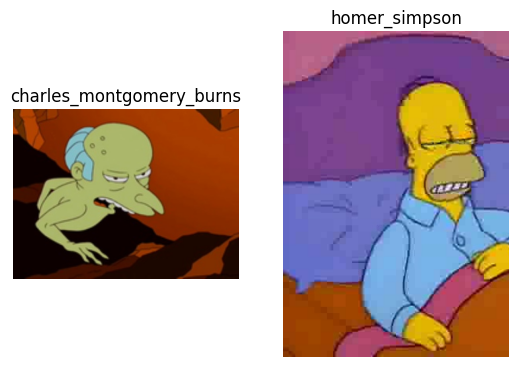

In [65]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Image.open('/content/train/simpsons_dataset/charles_montgomery_burns/pic_0000.jpg'))
ax[0].set_title(f"charles_montgomery_burns")
ax[0].axis("off")

ax[1].imshow(Image.open('/content/train/simpsons_dataset/homer_simpson/pic_0000.jpg'))
ax[1].set_title(f"homer_simpson")
ax[1].axis("off")

lisa_simpson принимается за bart_simpson - 11 ошибочных предсказаний

In [55]:
label_encoder.inverse_transform([4, 20])

array(['bart_simpson', 'lisa_simpson'], dtype='<U24')

(-0.5, 255.5, 288.5, -0.5)

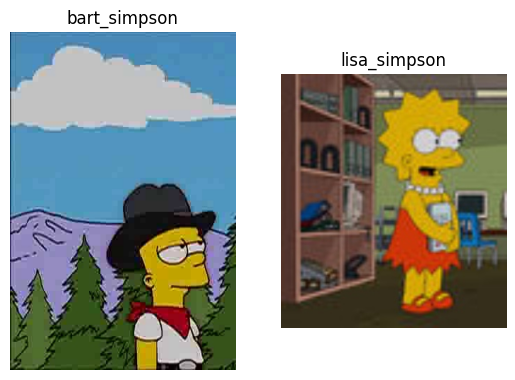

In [67]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Image.open('/content/train/simpsons_dataset/bart_simpson/pic_0000.jpg'))
ax[0].set_title(f"bart_simpson")
ax[0].axis("off")

ax[1].imshow(Image.open('/content/train/simpsons_dataset/lisa_simpson/pic_0000.jpg'))
ax[1].set_title(f"lisa_simpson")
ax[1].axis("off")

homer_simpson принимается за abraham_grampa_simpson - 16 ошибок



In [68]:
label_encoder.inverse_transform([0, 15])

array(['abraham_grampa_simpson', 'homer_simpson'], dtype='<U24')

(-0.5, 287.5, 415.5, -0.5)

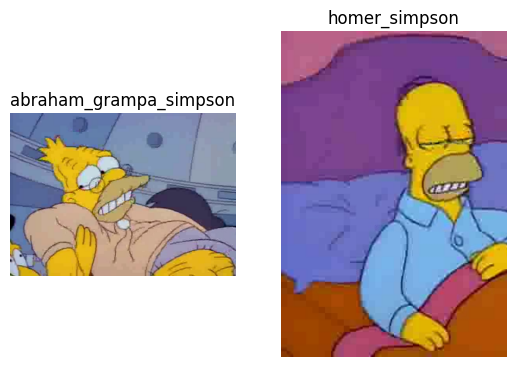

In [70]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Image.open('/content/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'))
ax[0].set_title(f"abraham_grampa_simpson")
ax[0].axis("off")

ax[1].imshow(Image.open('/content/train/simpsons_dataset/homer_simpson/pic_0000.jpg'))
ax[1].set_title(f"homer_simpson")
ax[1].axis("off")

Визуализируем прогноз на 9 случайных объектах тестовых данных

In [71]:
example, _ = torch.utils.data.random_split(val_dataset, [9, len(val_dataset) - 9])
example_loader = torch.utils.data.DataLoader(example, batch_size=9)

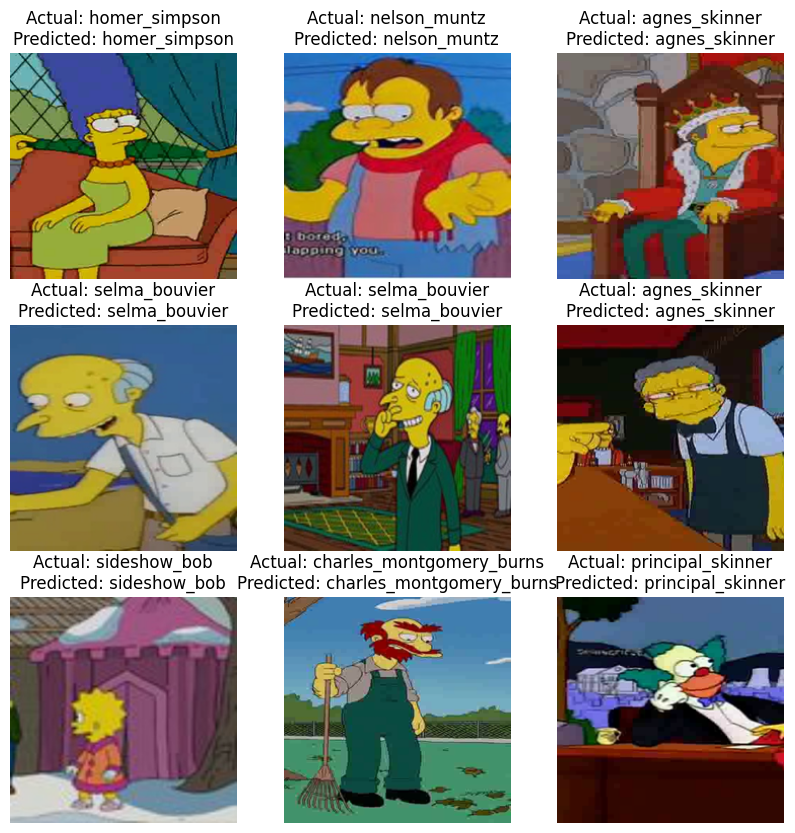

In [76]:
# переводим модель в режим оценки
trained_model.eval()

# получаем один батч из 9 картинок и меток
X, y = next(iter(example_loader))

# переводим батч на GPU
X, y = X.to(device), y.to(device)

# получаем предсказания модели для батча
pred = trained_model(X)

# выбираем наиболее вероятный класс для каждой картинки
pred = torch.argmax(pred, dim=1)

# создаем фигуру с 9 подграфиками
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# итерируем по картинкам, меткам и предсказаниям
for i, (img, label, prediction) in enumerate(zip(X, y, pred)):
    # определяем координаты подграфика
    row = i // 3
    col = i % 3
    # преобразуем тензоры для показа
    img =  img.cpu()
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    # отображаем картинку на подграфике
    axes[row, col].imshow(img.squeeze())
    # добавляем заголовок с фактическим и прогнозным классом
    axes[row, col].set_title(f'Actual: {class_names[label.item()]}\nPredicted: {class_names[prediction.item()]}')
    # убираем оси координат
    axes[row, col].axis('off')

# показываем фигуру
plt.show()

## Анализ времени и качества обучения моделей

In [77]:
df = pd.DataFrame({'model': ['AlexNet', 'VGG19', 'ResNet', 'AlexNet без заморозки'], 'accuracy': [0.81, 0.78, 0.68, 0.90], 'time': ['33 min 34s', '37min 39s', '33 min 52s', '33 min 30s']})

In [78]:
df

,model,accuracy,time
0,AlexNet,0.81,33 min 34s
1,VGG19,0.78,37min 39s
2,ResNet,0.68,33 min 52s
3,AlexNet без заморозки,0.90,33 min 30s


Все модели обучались на 18 эпохах. Наиболее хороший результат как по accuracy, так и по времени обучения, показала AlexNet без заморозки слоёв.

## Функция, которая классифицирует произвольное изображение

In [2]:
import requests
from io import BytesIO
from torchvision import transforms

In [82]:
url = 'https://dostavkaruservice.ru/wp-content/uploads/2020/05/pepperoni.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(size=(254, 254)),
    transforms.ToTensor()
])

In [ ]:
tr_image = test_transform(image)

print(f"Размерность тензора: {tr_image.shape}\n")

In [ ]:
# добавляем размерность, т.к. модель работает с батчами, а тут у нас одна картинка
tr_image_usqueezed = tr_image.unsqueeze(0)
tr_image_usqueezed.shape

In [ ]:
model.eval()

with torch.inference_mode():
    custom_image_pred = model(tr_image_usqueezed.to(device))
    custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

class_label = torch.argmax(custom_image_pred, dim=1)
pred = class_names[class_label]
print(custom_image_pred_probs)
print(pred)